In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
prediction_tasks = [pd.read_csv(f'results/prediction_sqf_rnn_task{task}.csv').set_index(['TIMESTAMP', 'ZONEID'])
                    for task in range(4, 16)]
prediction = pd.concat(prediction_tasks)
prediction = prediction.sort_index()

actual = pd.read_csv('data/Task 16/train16.csv', parse_dates=['TIMESTAMP'])
actual = actual[actual['TIMESTAMP'] >= '2013-07-01 01:00'].set_index(['TIMESTAMP', 'ZONEID'])
actual = actual.sort_index()

In [3]:
prediction

0.01      0.02      0.03      0.04      0.05  \
TIMESTAMP           ZONEID                                                     
2013-07-01 01:00:00 1       0.139890  0.141361  0.142382  0.143615  0.144480   
                    2       0.174285  0.175803  0.177178  0.178324  0.179734   
                    3       0.505686  0.508436  0.510239  0.512010  0.514704   
2013-07-01 02:00:00 1       0.165518  0.174711  0.179751  0.186853  0.192221   
                    2       0.219471  0.230936  0.238201  0.245168  0.251242   
...                              ...       ...       ...       ...       ...   
2014-06-30 23:00:00 2       0.035575  0.040336  0.043430  0.047187  0.049438   
                    3       0.086823  0.095938  0.101493  0.107062  0.113486   
2014-07-01 00:00:00 1       0.129269  0.142842  0.154159  0.159357  0.164843   
                    2       0.123326  0.137030  0.147095  0.152884  0.160028   
                    3       0.161061  0.176402  0.190375  0.199222  0.207394   

                                0.06      0.07      0.08      0.09       0.1  \
TIMESTAMP           ZONEID                                                     
2013-07-01 01:00:00 1       0.146115  0.147341  0.148777  0.150433  0.151907   
                    2       0.181069  0.182412  0.184200  0.186038  0.187354   
                    3       0.516633  0.518795  0.520979  0.523395  0.525748   
2013-07-01 02:00:00 1       0.196362  0.201580  0.206390  0.210029  0.213856   
                    2       0.254942  0.258729  0.263156  0.267557  0.272039   
...                              ...       ...       ...       ...       ...   
2014-06-30 23:00:00 2       0.051947  0.054328  0.056029  0.058072  0.060080   
                    3       0.118441  0.121705  0.125468  0.128535  0.132441   
2014-07-01 00:00:00 1       0.169882  0.175112  0.180378  0.184715  0.190083   
                    2       0.165391  0.171128  0.175071  0.179784  0.183317   
                    3       0.213804  0.220318  0.225671  0.230740  0.237117   

                            ...       0.9      0.91      0.92      0.93  \
TIMESTAMP           ZONEID  ...                                           
2013-07-01 01:00:00 1       ...  0.315718  0.318315  0.320637  0.322936   
                    2       ...  0.353706  0.356151  0.358356  0.360769   
                    3       ...  0.656129  0.657809  0.659951  0.662546   
2013-07-01 02:00:00 1       ...  0.405427  0.409498  0.411973  0.416341   
                    2       ...  0.466464  0.470232  0.473348  0.478148   
...                         ...       ...       ...       ...       ...   
2014-06-30 23:00:00 2       ...  0.193992  0.197570  0.200950  0.205181   
                    3       ...  0.348368  0.354302  0.359623  0.366722   
2014-07-01 00:00:00 1       ...  0.447254  0.454351  0.459760  0.470394   
                    2       ...  0.425606  0.432189  0.437573  0.446332   
                    3       ...  0.523675  0.529912  0.538881  0.547304   

                                0.94      0.95      0.96      0.97      0.98  \
TIMESTAMP           ZONEID                                                     
2013-07-01 01:00:00 1       0.325005  0.326594  0.329033  0.331053  0.332729   
                    2       0.362352  0.365031  0.367148  0.368835  0.370998   
                    3       0.664895  0.666601  0.668144  0.670236  0.672513   
2013-07-01 02:00:00 1       0.420205  0.424556  0.429901  0.435531  0.441635   
                    2       0.483356  0.488029  0.495091  0.500400  0.508464   
...                              ...       ...       ...       ...       ...   
2014-06-30 23:00:00 2       0.211272  0.217111  0.225773  0.233238  0.244466   
                    3       0.374404  0.381785  0.389721  0.403519  0.419887   
2014-07-01 00:00:00 1       0.475773  0.484415  0.491917  0.507511  0.522713   
                    2       0.453051  0.460340  0.471552  0.480469  0.497102   
              

In [4]:
def sample(quantiles, n):
    ps = np.random.choice(a=[str(p / 100) for p in range(1, 100)], size=n, replace=True)
    xs = quantiles[ps]
    return np.array(xs)[None,...]

sampled = sample(prediction.iloc[0], 20)

In [5]:
from tqdm import tqdm

def energy_score(quantiles, y, n=100):
    """
    Calculates the energy score.
    :param quantiles: np array (99,d)
    :param y: (d,)
    :param n: number of samples
    :return: energy score of the prediction
    """
    xs = np.squeeze(sample(quantiles, n))
    s1 = np.mean(np.linalg.norm(xs - y, axis=0))
    s2 = - 1 / 2 * np.mean(np.linalg.norm(xs[None, ...] - xs[None, ...].T, axis=1))
    return s1 + s2

horizon = 24

scores = []

for zone in range(1, 4):
    pred = prediction.query(f'ZONEID == {zone}')
    act = actual.query(f'ZONEID == {zone}')

    score = np.empty(len(pred) - horizon)
    for i in tqdm(range(len(pred) - horizon)):
        score[i] = energy_score(pred.iloc[i:i+horizon], np.array(act.iloc[i:i+horizon]))

    scores.append(score)

print(f'Energy score: {(scores[0].mean() + scores[1].mean() + scores[2].mean()) / 3}')

100%|██████████| 8736/8736 [00:09<00:00, 965.21it/s] 

Energy score: 0.3591716287919906


In [6]:
def cdf(quantiles, x):
    s = x <= quantiles
    if len(s[s==True]) == 0:
        return 0
    return float(s[s==True].index[0])

In [7]:
pits = {hour: [] for hour in range(24)}
for hour in range(24):
    for day in range(len(prediction) // (24 * 3)):
        for task in range(3):
            quantiles = prediction.iloc[hour + (24 * 3) * day + task]
            y = float(actual.iloc[hour + (24 * 3) * day + task])
            pit_value = cdf(quantiles, y)
            if y == 0:
                # if point mass exists, sample from [0, F(y)]
                pits[(hour + 1) % 24].append(np.random.uniform(0, cdf(quantiles, y)))
            else:
                pits[(hour + 1) % 24].append(pit_value)

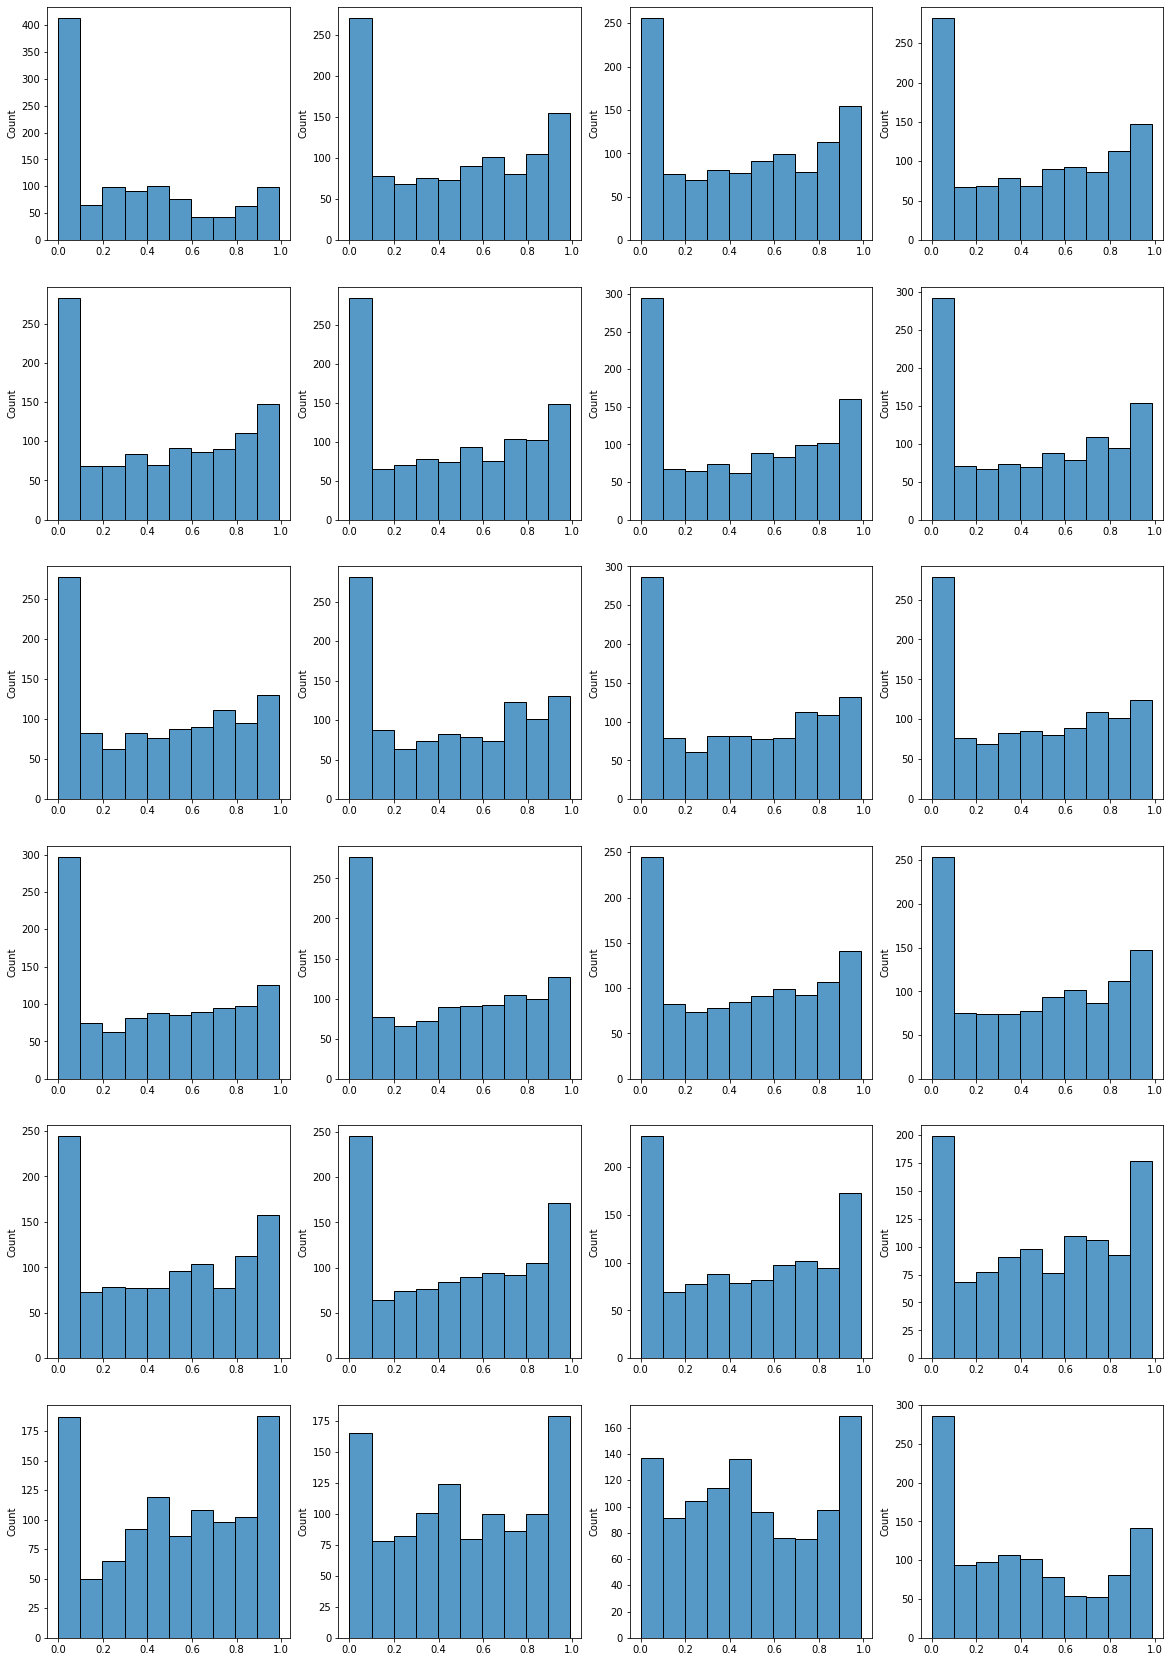

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(20, 30))

for hour in range(24):
    sns.histplot(data=np.array(pits[hour]), bins=10, ax=axs[hour // 4][hour % 4])